In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
#import pickle
import cv2
import os
import pandas as pd
from PIL import Image
#import imutils

In [2]:
all_ann = pd.read_csv("lib/datasets/LISA/allAnnotations.csv", delimiter=';')
# all_ann = all_ann.drop_duplicates(subset=["Filename"], keep=False, ignore_index=True)
# all_ann = all_ann.reset_index()

In [3]:
all_ann

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
2,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,922,88,982,148,"1,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [13]:
all_ann["Filename"][0]

'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png'

In [44]:
dupes = all_ann[all_ann["Occluded,On another road"] == "0,0"]
dupes = dupes[dupes.duplicated(subset=["Filename"], keep=False).tolist()]
dupes = dupes.groupby("Filename")
list(dupes.groups.keys())

['aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image10.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image11.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image12.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image13.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image14.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image15.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image16.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/leftTurn_1330546134.avi_image17.png',
 'aiua120214-0/frameAnnotations-DataLog02142012_external

In [45]:
import random
data = []
labels = []
width = 299
height = 299
df = all_ann[all_ann["Occluded,On another road"] == "0,0"]
sample = random.sample(list(range(len(dupes["Filename"]))), k=1000)
path = "lib/datasets/LISA/"
for i in range(len(df["Filename"])):
    file = df["Filename"][i]
    sign = df["Annotation tag"][i]
    image = Image.open(path + file)
    rng = random.randint(2,12)
    negative = Image.open("lib/datasets/vid_negatives/Screenshot"+rng+".png")
    n_size, i_size = negative.size, image.size
    group = dupes.get_group(file)
    bb = (group["Upper left corner X"][i], group["Upper left corner Y"][i], group["Lower right corner X"][i], group["Lower right corner Y"][i])
    tmp = image.crop(bb)
    x_r = n_size[0] / i_size[0]
    y_r = n_size[1] / i_size[1]
    reshape = (int(bb[2] * x_r - bb[0] * x_r), int(bb[2] * x_r - bb[0] * x_r))
    tmp = tmp.resize(reshape)
    negative.paste(tmp, (int(bb[0] * x_r), int(bb[1] * y_r)))
    negative.resize((width,height))
    image = np.asarray(negative)
    data.append(image)
    labels.append(sign)


,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2


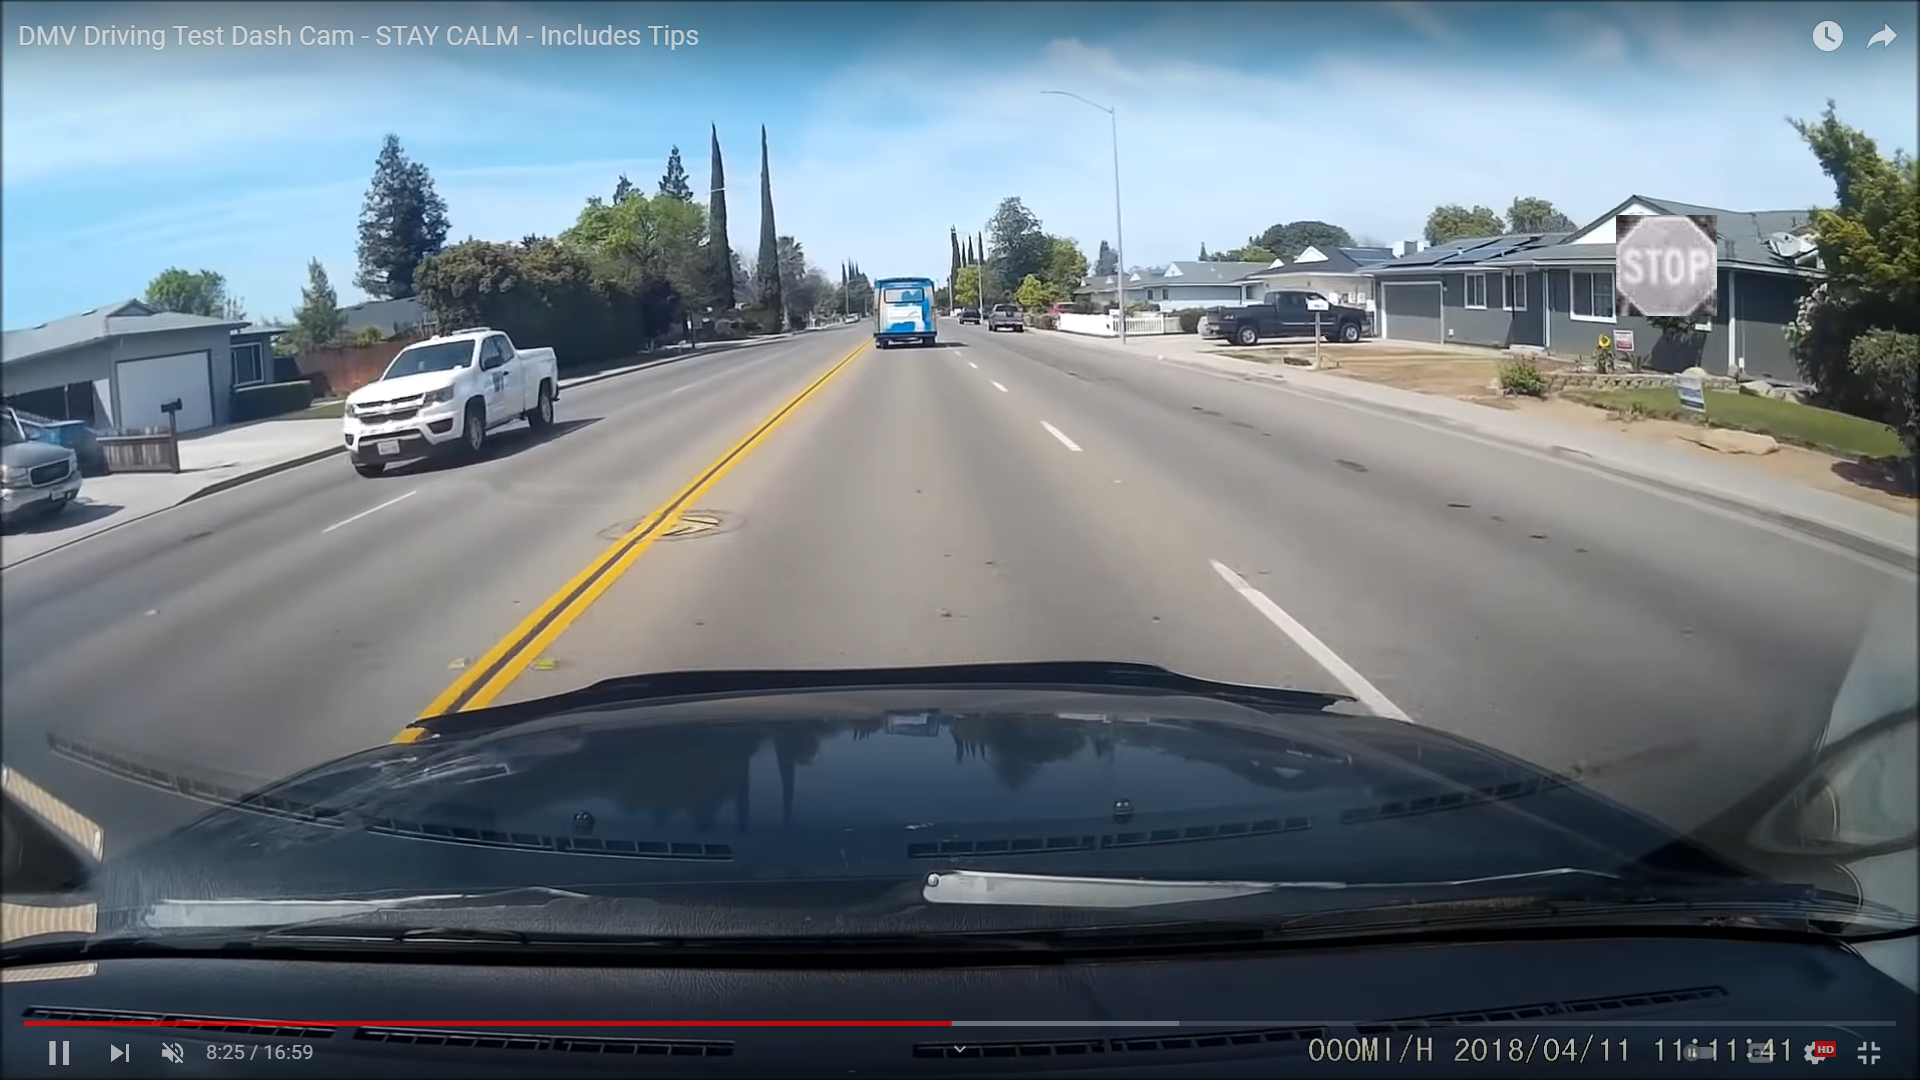

In [41]:
i = 0
path = "lib/datasets/LISA/"
file = 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png'
image = Image.open(path + file)
negative = Image.open("lib/datasets/vid_negatives/Screenshot1.png")
n_size, i_size = negative.size, image.size
group = dupes.get_group(file)
bb = (group["Upper left corner X"][i], group["Upper left corner Y"][i], group["Lower right corner X"][i], group["Lower right corner Y"][i])
tmp = image.crop(bb)
x_r = n_size[0] / i_size[0]
y_r = n_size[1] / i_size[1]
reshape = (int(bb[2] * x_r - bb[0] * x_r), int(bb[2] * x_r - bb[0] * x_r))
tmp = tmp.resize(reshape)
negative.paste(tmp, (int(bb[0] * x_r), int(bb[1] * y_r)))
negative

In [32]:
path = "lib/datasets/LISA/"
file = 'aiua120214-0/frameAnnotations-DataLog02142012_external_camera.avi_annotations/stop_1330545910.avi_image0.png'
image = Image.open(path + file)
#display(image)

In [33]:
negative = Image.open("lib/datasets/vid_negatives/Screenshot1.png")
#display(negative)

In [24]:
negative.size, image.size

((1920, 1080), (1024, 522))

In [35]:
group = dupes.get_group(file)
bb = (group["Upper left corner X"][0], group["Upper left corner Y"][0], group["Lower right corner X"][0], group["Lower right corner Y"][0])
tmp = image.crop(bb)
#display(tmp)

In [34]:
tmp1 = tmp.resize((101,101))
#tmp1

In [36]:
final =  negative.copy()
final.paste(tmp1, (1616,215))
#final

In [43]:
import random
tmp_data = all_ann[all_ann["Occluded,On another road"] == "0,0"]
tmp_data

,Filename,Annotation tag,Upper left corner X,Upper left corner Y,Lower right corner X,Lower right corner Y,"Occluded,On another road",Origin file,Origin frame number,Origin track,Origin track frame number
0,aiua120214-0/frameAnnotations-DataLog02142012_...,stop,862,104,916,158,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
1,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimitUrdbl,425,197,438,213,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2667,stop_1330545910.avi,2
3,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,447,193,461,210,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2672,stop_1330545910.avi,7
4,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,469,189,483,207,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2677,stop_1330545910.avi,12
5,aiua120214-0/frameAnnotations-DataLog02142012_...,speedLimit25,529,183,546,203,"0,0",aiua120214-0/DataLog02142012_external_camera.avi,2717,speedLimit_1330545914.avi,2
...,...,...,...,...,...,...,...,...,...,...,...
7850,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,41,209,65,239,"0,0",vid9/MVI_0121.MOV,8813,speedLimit_1324866802.avi,22
7851,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,526,213,543,233,"0,0",vid9/MVI_0121.MOV,8875,speedLimit_1324866807.avi,2
7852,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,546,208,564,230,"0,0",vid9/MVI_0121.MOV,8880,speedLimit_1324866807.avi,7
7853,vid9/frameAnnotations-MVI_0121.MOV_annotations...,speedLimit35,573,204,592,228,"0,0",vid9/MVI_0121.MOV,8885,speedLimit_1324866807.avi,12


In [42]:
all_ann.columns

Index(['Filename', 'Annotation tag', 'Upper left corner X',
       'Upper left corner Y', 'Lower right corner X', 'Lower right corner Y',
       'Occluded,On another road', 'Origin file', 'Origin frame number',
       'Origin track', 'Origin track frame number'],
      dtype='object')